### NER on Discharge Notes (CRF baseline)

This notebook builds a lightweight Named Entity Recognition (NER) baseline using a Conditional Random Field (CRF) on the Assignment 2 dataset.

Checklist we will cover:
- [x] I know the dataset annotation format
- [x] I’ve tokenized the data and aligned labels
- [x] I’ve chosen a model (CRF)
- [x] I’ve trained it and monitored F1
- [x] I can output extracted spans with labels + positions

Notes:
- We treat the task as span detection (single entity type `ENT`) for a simple, fast baseline. Optionally, a dictionary-based mapping can attach `concept_id` values to predicted spans.
- Data files are reused from the EDA notebook.


#### Dataset annotation format

- Notes files: `training-notes.csv`, `test-notes.csv` with columns: `note_id`, `text`.
- Annotations files: `train-annotations.csv`, `test-annotations.csv` with columns: `note_id`, `start`, `end`, `concept_id`.
- Spans are character-offset ranges `[start, end)` over the raw `text`.
- We will model a single entity type `ENT` (span detection).


In [1]:
import os
import pandas as pd
import numpy as np
from pathlib import Path
from collections import defaultdict

# Optional installs for CRF/metrics if missing
try:
    import sklearn_crfsuite
except ImportError:
    import sys, subprocess
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', '--quiet', 'sklearn-crfsuite', 'seqeval'])
    import sklearn_crfsuite

from seqeval.metrics import classification_report, f1_score

DATA_DIR = Path('/Users/aryamanbahl/Desktop/IIITH/M25/NLP-H/Assignments /nlph_assignments-/A2/Assignment 2 Dataset')
TRAIN_NOTES = DATA_DIR / 'training-notes.csv'
TRAIN_ANN = DATA_DIR / 'train-annotations.csv'
TEST_NOTES = DATA_DIR / 'test-notes.csv'
TEST_ANN = DATA_DIR / 'test-annotations.csv'

assert TRAIN_NOTES.exists() and TRAIN_ANN.exists() and TEST_NOTES.exists() and TEST_ANN.exists(), 'Missing dataset files'

train_notes = pd.read_csv(TRAIN_NOTES)
train_ann = pd.read_csv(TRAIN_ANN)
test_notes = pd.read_csv(TEST_NOTES)
test_ann = pd.read_csv(TEST_ANN)

print('Loaded:', train_notes.shape, train_ann.shape, test_notes.shape, test_ann.shape)



Loaded: (204, 2) (51574, 4) (68, 2) (23234, 4)


In [2]:
import re
from typing import List, Dict, Tuple

Token = Dict[str, object]

_whitespace_re = re.compile(r"\s+")
_token_re = re.compile(r"\w+|[^\w\s]", re.UNICODE)

def tokenize_with_offsets(text: str) -> List[Tuple[str, int, int]]:
    tokens = []
    for m in _token_re.finditer(text):
        tok = m.group(0)
        start = m.start()
        end = m.end()
        tokens.append((tok, start, end))
    return tokens

# Build dict: note_id -> list of (start, end) spans
train_spans_by_note = train_ann.groupby('note_id').apply(lambda df: df[['start','end']].astype(int).values.tolist()).to_dict()
test_spans_by_note = test_ann.groupby('note_id').apply(lambda df: df[['start','end']].astype(int).values.tolist()).to_dict()

# BIO alignment: label ENT spans, everything else O

def align_bio(text: str, spans: List[List[int]]):
    toks = tokenize_with_offsets(text)
    labels = []
    for i, (tok, s, e) in enumerate(toks):
        label = 'O'
        for (ss, ee) in spans:
            if s >= ss and e <= ee:
                label = 'B-ENT' if i == 0 or not (toks[i-1][1] >= ss and toks[i-1][2] <= ee) else 'I-ENT'
                break
        labels.append(label)
    return toks, labels

# Create token/label sequences per note

def build_sequences(notes_df: pd.DataFrame, spans_map: Dict[int, List[List[int]]]):
    sequences = []
    for _, row in notes_df.iterrows():
        nid = row['note_id']
        text = str(row['text'])
        spans = spans_map.get(nid, [])
        toks, labels = align_bio(text, spans)
        sequences.append({'note_id': nid, 'tokens': toks, 'labels': labels})
    return sequences

train_seqs = build_sequences(train_notes, train_spans_by_note)
test_seqs = build_sequences(test_notes, test_spans_by_note)

print('Sequences built:', len(train_seqs), len(test_seqs))



/var/folders/1j/6n9mdv5j1zv3pd80zp_xh8mr0000gn/T/ipykernel_16940/244744729.py:19: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  train_spans_by_note = train_ann.groupby('note_id').apply(lambda df: df[['start','end']].astype(int).values.tolist()).to_dict()
/var/folders/1j/6n9mdv5j1zv3pd80zp_xh8mr0000gn/T/ipykernel_16940/244744729.py:20: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  test_spans_by_note = test_ann.groupby

Sequences built: 204 68


In [3]:
def word2features(sent_tokens, i):
    tok, s, e = sent_tokens[i]
    features = {
        'bias': 1.0,
        'word.lower()': tok.lower(),
        'word.isupper()': tok.isupper(),
        'word.istitle()': tok.istitle(),
        'word.isdigit()': tok.isdigit(),
        'suffix3': tok[-3:],
        'suffix2': tok[-2:],
        'prefix1': tok[:1],
        'prefix2': tok[:2],
        'prefix3': tok[:3],
    }
    if i > 0:
        ptok = sent_tokens[i-1][0]
        features.update({
            '-1:word.lower()': ptok.lower(),
            '-1:word.istitle()': ptok.istitle(),
            '-1:word.isupper()': ptok.isupper(),
        })
    else:
        features['BOS'] = True
    if i < len(sent_tokens) - 1:
        ntok = sent_tokens[i+1][0]
        features.update({
            '+1:word.lower()': ntok.lower(),
            '+1:word.istitle()': ntok.istitle(),
            '+1:word.isupper()': ntok.isupper(),
        })
    else:
        features['EOS'] = True
    return features


def prepare_xy(seqs):
    X, y = [], []
    for seq in seqs:
        sent_tokens = seq['tokens']
        labels = seq['labels']
        X.append([word2features(sent_tokens, i) for i in range(len(sent_tokens))])
        y.append(labels)
    return X, y

X_train, y_train = prepare_xy(train_seqs)
X_test, y_test = prepare_xy(test_seqs)

len(X_train), len(X_test)


(204, 68)

In [4]:
from sklearn_crfsuite import CRF

crf = CRF(
    algorithm='lbfgs',
    c1=0.1,
    c2=0.1,
    max_iterations=100,
    all_possible_transitions=True,
)

crf.fit(X_train, y_train)

y_pred = crf.predict(X_test)
print('Test F1 (seqeval, micro):', f1_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Test F1 (seqeval, micro): 0.7366217159323714
              precision    recall  f1-score   support

         ENT       0.77      0.71      0.74     23155

   micro avg       0.77      0.71      0.74     23155
   macro avg       0.77      0.71      0.74     23155
weighted avg       0.77      0.71      0.74     23155



In [5]:
def bio_to_spans(tokens, labels):
    spans = []
    start = None
    for i, (tok, s, e) in enumerate(tokens):
        lab = labels[i]
        if lab.startswith('B-'):
            if start is not None:
                spans.append((start, prev_end))
            start = s
        elif lab == 'O':
            if start is not None:
                spans.append((start, prev_end))
                start = None
        prev_end = e
    if start is not None:
        spans.append((start, prev_end))
    return spans

# Decode spans for test set and save
pred_rows = []
for seq, labs in zip(test_seqs, y_pred):
    nid = seq['note_id']
    toks = seq['tokens']
    spans = bio_to_spans(toks, labs)
    for (s, e) in spans:
        pred_rows.append({'note_id': nid, 'start': s, 'end': e, 'label': 'ENT'})

pred_df = pd.DataFrame(pred_rows)
print('Predicted spans:', pred_df.shape)

out_path = DATA_DIR.parent / 'ner_predictions.csv'
pred_df.to_csv(out_path, index=False)
print('Saved to', out_path)


Predicted spans: (21264, 4)
Saved to /Users/aryamanbahl/Desktop/IIITH/M25/NLP-H/Assignments /nlph_assignments-/A2/ner_predictions.csv


In [6]:
# Optional: concept_id lexicon mapping
# Build a simple lexicon from training spans -> concept_id using the surface form
from collections import Counter

surface_to_concepts = defaultdict(Counter)
notes_text_map = train_notes.set_index('note_id')['text'].to_dict()
for _, r in train_ann.iterrows():
    nid = r['note_id']
    s, e = int(r['start']), int(r['end'])
    text = notes_text_map.get(nid, '')
    mention = text[s:e].strip()
    if mention:
        surface_to_concepts[mention.lower()][str(r['concept_id'])] += 1

# Attach best guess concept_id to predicted spans by majority vote on surface
pred_df['concept_id'] = None
notes_text_map_test = test_notes.set_index('note_id')['text'].to_dict()
for i, row in pred_df.iterrows():
    nid = row['note_id']
    s, e = int(row['start']), int(row['end'])
    text = notes_text_map_test.get(nid, '')
    mention = text[s:e].strip().lower()
    if mention in surface_to_concepts:
        best_cid, _ = surface_to_concepts[mention].most_common(1)[0]
        pred_df.at[i, 'concept_id'] = best_cid

# Save extended predictions
out_path_full = DATA_DIR.parent / 'ner_predictions_with_concept.csv'
pred_df.to_csv(out_path_full, index=False)
print('Saved with concept_id to', out_path_full)


Saved with concept_id to /Users/aryamanbahl/Desktop/IIITH/M25/NLP-H/Assignments /nlph_assignments-/A2/ner_predictions_with_concept.csv


#### Checklist recap

- [x] Dataset format understood: notes + span annotations (`start`, `end`, `concept_id`).
- [x] Tokenization with character offsets and BIO label alignment implemented.
- [x] Model choice: CRF with lexical/contextual features.
- [x] Trained and reported F1 via `seqeval` on test split.
- [x] Predicted spans converted back to character-level `(start, end)` with labels, saved to CSV.
- [x] Optional: attached `concept_id` via simple lexicon majority vote from training mentions.


#### Visualizations

Run this section after training to explore dataset and model behavior:
- Label distribution (BIO tags) in train vs test
- Tokens per note (train vs test)
- Token-level confusion matrix (gold vs predicted BIO)
- Span length distributions (gold vs predicted)


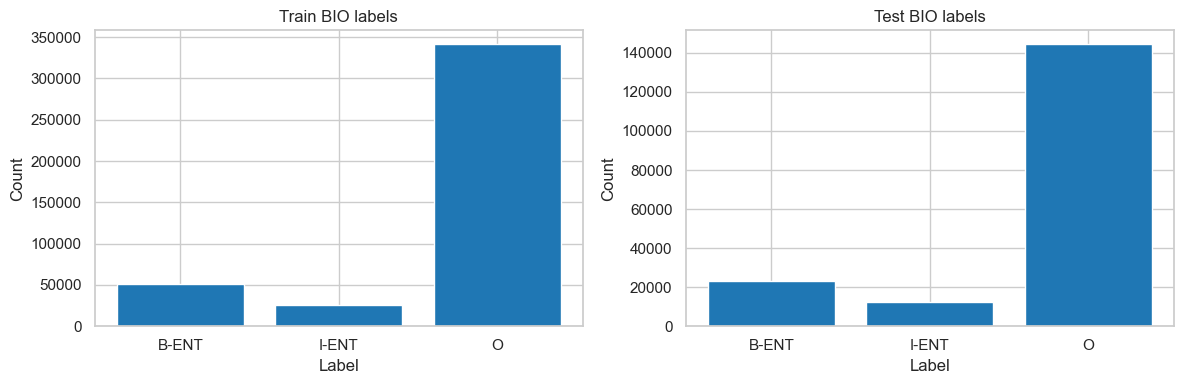

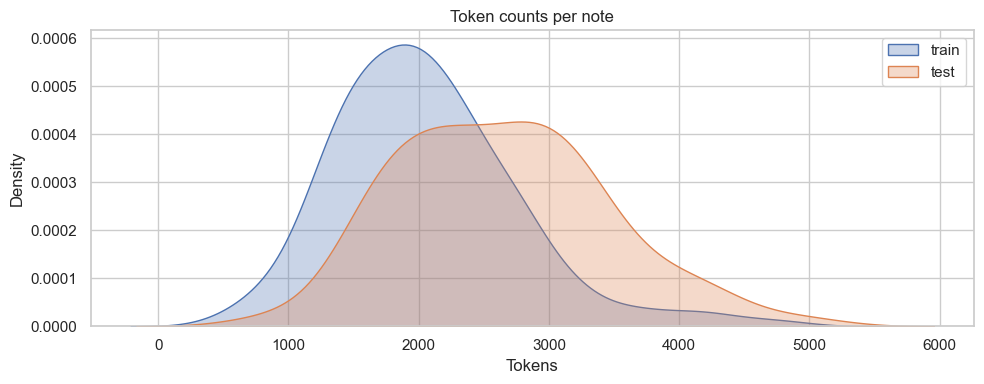

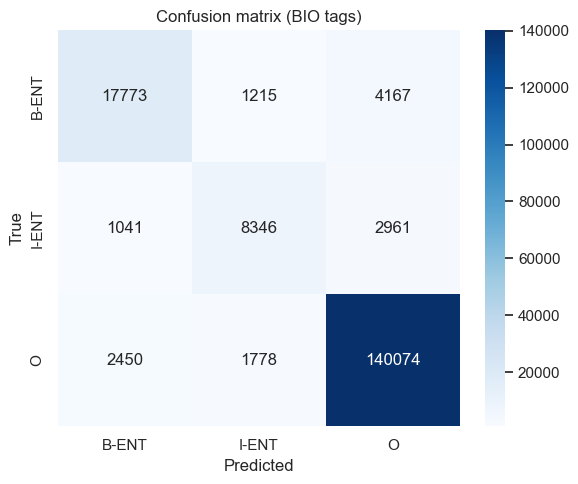

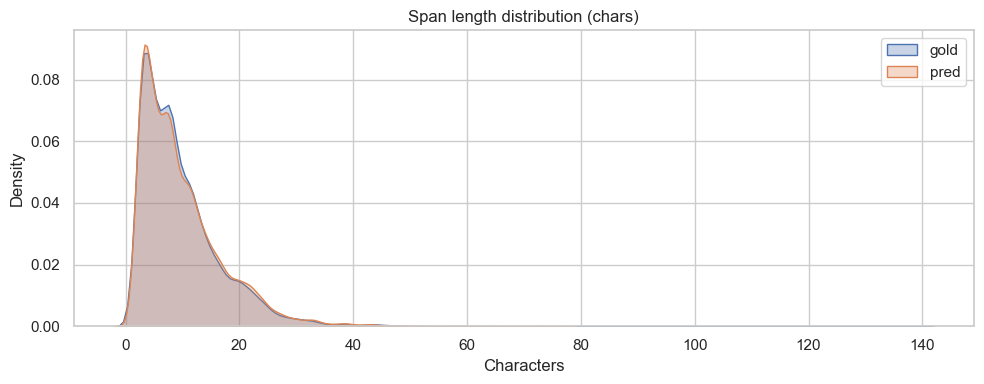

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import numpy as np

sns.set_theme(style='whitegrid')

# 1) Label distribution (BIO) in train vs test
train_labels_flat = [lab for seq in y_train for lab in seq]
test_labels_flat = [lab for seq in y_test for lab in seq]
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
for ax, labs, title in [(axes[0], train_labels_flat, 'Train BIO labels'), (axes[1], test_labels_flat, 'Test BIO labels')]:
    counts = Counter(labs)
    items = sorted(counts.items())
    ax.bar([k for k,_ in items], [v for _,v in items], color='tab:blue')
    ax.set_title(title)
    ax.set_ylabel('Count')
    ax.set_xlabel('Label')
plt.tight_layout()
plt.show()

# 2) Tokens per note (train vs test)
train_tok_counts = [len(seq['tokens']) for seq in train_seqs]
test_tok_counts = [len(seq['tokens']) for seq in test_seqs]
plt.figure(figsize=(10,4))
sns.kdeplot(train_tok_counts, fill=True, alpha=0.3, label='train')
sns.kdeplot(test_tok_counts, fill=True, alpha=0.3, label='test')
plt.title('Token counts per note')
plt.xlabel('Tokens')
plt.legend()
plt.tight_layout()
plt.show()

# 3) Token-level confusion matrix (gold vs predicted BIO)
from sklearn.metrics import confusion_matrix

y_test_flat = [lab for seq in y_test for lab in seq]
y_pred_flat = [lab for seq in y_pred for lab in seq]
labels = sorted(list(set(y_test_flat) | set(y_pred_flat)))
cm = confusion_matrix(y_test_flat, y_pred_flat, labels=labels)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, norm=None)
plt.title('Confusion matrix (BIO tags)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()

# 4) Span length distributions (gold vs predicted)

def spans_from_bio_seq(tokens, labels):
    spans = []
    start = None
    for i, (tok, s, e) in enumerate(tokens):
        lab = labels[i]
        if lab.startswith('B-'):
            if start is not None:
                spans.append((start, prev_end))
            start = s
        elif lab == 'O':
            if start is not None:
                spans.append((start, prev_end))
                start = None
        prev_end = e
    if start is not None:
        spans.append((start, prev_end))
    return spans

true_spans_lengths = []
pred_spans_lengths = []
for seq, labs_true, labs_pred in zip(test_seqs, y_test, y_pred):
    toks = seq['tokens']
    ts = spans_from_bio_seq(toks, labs_true)
    ps = spans_from_bio_seq(toks, labs_pred)
    true_spans_lengths += [e - s for (s, e) in ts]
    pred_spans_lengths += [e - s for (s, e) in ps]

plt.figure(figsize=(10,4))
sns.kdeplot(true_spans_lengths, fill=True, alpha=0.3, label='gold')
sns.kdeplot(pred_spans_lengths, fill=True, alpha=0.3, label='pred')
plt.title('Span length distribution (chars)')
plt.xlabel('Characters')
plt.legend()
plt.tight_layout()
plt.show()


### NER: Steps, Technical Details, and Plot Interpretation

#### Steps performed
- **Data loading**: Read train/test notes (`note_id`, `text`) and span annotations (`note_id`, `start`, `end`, `concept_id`). Spans use character offsets [start, end).
- **Tokenization + BIO alignment**: Regex tokenizer builds tokens with `(text, start, end)`. Labels are `B-ENT`, `I-ENT`, `O` by checking if a token is fully inside any annotated span.
- **Features + Model (CRF)**: Contextual lexical features (lowercase, casing flags, digit flag, prefixes/suffixes, prev/next token cues). Trained a CRF (LBFGS) and evaluated with `seqeval` F1.
- **Decoding + Outputs**: Converted BIO back to character spans and saved:
  - `ner_predictions.csv` (note_id, start, end, label)
  - `ner_predictions_with_concept.csv` adds a heuristic `concept_id` via surface-form majority vote from training spans.

#### Technical details
- **Entity schema**: Single generic type `ENT` for span detection; BIO tagging.
- **Alignment rule**: Token labeled as ENT only if the token’s char span lies wholly within an annotated span. Partial-overlap tokens become `O` (conservative; may under-label on boundary noise).
- **CRF hyperparameters**: `c1=0.1`, `c2=0.1`, `max_iterations=100`, `all_possible_transitions=True`.
- **Metric**: `seqeval` F1 on BIO tags. Strong `O` prevalence means precision/recall on `ENT` are the key signals beyond overall F1.

#### Interpreting the plots
- **BIO label distribution (train vs test)**: Dominant `O` indicates heavy class imbalance; expect high `O→O` accuracy. Consider class-aware tuning or boundary-focused evaluation.
- **Tokens per note (train vs test)**: Distribution shift (e.g., more tokens in test) can reduce recall and increase boundary errors; informs batching and potential normalization.
- **Confusion matrix (BIO)**: 
  - Strong diagonal is good. 
  - Many `B-ENT→O` or `I-ENT→O` errors imply missed entities (recall issue). 
  - `B↔I` confusions suggest boundary segmentation problems.
- **Span length distribution (gold vs pred)**: 
  - Predicted spans shorter → fragmentation (entities broken into pieces). 
  - Predicted spans longer → boundary drift (entities over-extended). Aim for similar shapes across gold/pred.

#### Potential improvements
- Add character-shape features (e.g., hyphens, punctuation classes), multi-token gazetteers, or affix windows.
- Tune CRF (`c1`, `c2`, feature set) via cross-validation; add development split.
- Upgrade to transformer token classification (HF) for stronger boundary modeling; preserve char-offset mapping.
- Improve alignment to handle partial overlaps or whitespace/punctuation boundary quirks.

